In [1]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run functions/formatting.py ./
%run functions/color_functions.py ./

Load NSE and cyclostationary NSE results.

In [2]:
Ncombinations=1694
Nbasins=189
data_TWS='GRACE_JPL_mascons'
NSE_tab=pd.read_csv("outputs/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ncombinations,data_TWS),index_col=[0])
NSEc_tab=pd.read_csv("outputs/NSE_cyclic_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ncombinations,data_TWS),index_col=[0])

Select only basins with a good water budget closure (max NSE larger than 0.8 or max cyclostationary NSE larger than 0.1).

In [3]:
good_basins=NSE_tab.index[(np.nanmax(NSE_tab,axis=1)>=0.8)|(np.nanmax(NSEc_tab,axis=1)>=0.1)]

# 1. Hierarchical clustering

Compute the cost matrix as the difference between the maximum NSE and the NSE for each combination.

In [4]:
cost=np.nanmax(NSE_tab.loc[good_basins],axis=1).reshape(-1,1)-NSE_tab.loc[good_basins]

# restrict maximum values to 2 and replace nans by 2
cost=np.where((cost>2)|np.isnan(cost),2,cost)

Perform the hierarchical clustering based on the Euclidean distance (implicit when linkage is `ward`) and minimizing the variance between clusters (`ward`).

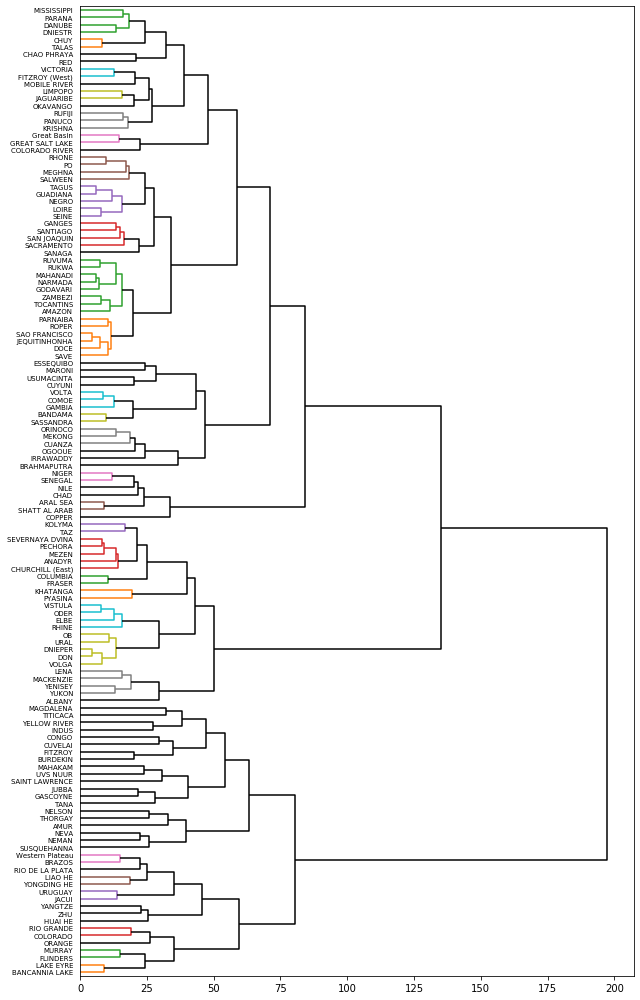

In [5]:
linkage='ward'

plt.figure(figsize=(9,14))
dend = shc.dendrogram(shc.linkage(cost, method=linkage),
                      orientation='right',leaf_font_size=7,
                      color_threshold=19.5,above_threshold_color='k',
                      labels=good_basins)
plt.tight_layout()
plt.show()

There is no formal way to determine the clusters. The dendogram only gives an indication of clusters. Based on this, we choose the clusters "by hand".

In [6]:
clusters=pd.Series(0,index=good_basins)
clusters.loc[['LAKE EYRE','MURRAY', 'FLINDERS', #'BANCANNIA LAKE', 
             ]]='East Australia'
clusters.loc[['MEZEN', 'PECHORA', 'SEVERNAYA DVINA']]='West Russia'
clusters.loc[['VOLGA', 'DON', 'DNIEPER', 'URAL', 'OB']]='Volga'
clusters.loc[['RHINE', 'ELBE', 'ODER', 'VISTULA']]='Elbe'
clusters.loc[['YUKON','MACKENZIE']]='Mackenzie'
clusters.loc[['LENA', 'YENISEY']]='Lena'
clusters.loc[['SAVE', 'DOCE', 'JEQUITINHONHA', 'SAO FRANCISCO', 'ROPER', 'PARNAIBA']]='Brazil'
clusters.loc[['AMAZON', 'TOCANTINS', 'ZAMBEZI', 'GODAVARI', 'NARMADA', 'MAHANADI','RUKWA', 'RUVUMA']]='Amazon'
clusters.loc[['DNIESTR', 'DANUBE', 'PARANA', 'MISSISSIPPI']]='Mississippi'
clusters.loc[['RED', 'SALWEEN', 'MEKONG']]='Mekong'
clusters.loc[['NILE', 'SENEGAL', 'NIGER','CHAD']]='Central Africa'
clusters.loc[['YANGTZE','ZHU']]='Yangtze'
clusters.loc[['SAN JOAQUIN', 'GANGES', 'SACRAMENTO', 'TAGUS', 'GUADIANA']]='Ganges'

Assign a color to each cluster

In [7]:
dict_color_cluster={
    'Amazon':'deepskyblue',
    'Brazil':'tab:orange',
    'Central Africa':'limegreen',
    'West Russia':'tab:red',
    'Mississippi':'violet',
    'Ganges':'tab:brown',
    'East Australia':'gold',
    'Lena':'tab:gray',
    'Mekong':'rebeccapurple',
    'Elbe':'tab:cyan',
    'Volga':'forestgreen',
    'Yangtze':'tab:olive',
    'Mackenzie':'mediumblue'
}

Draw the dendogram with the new clusters

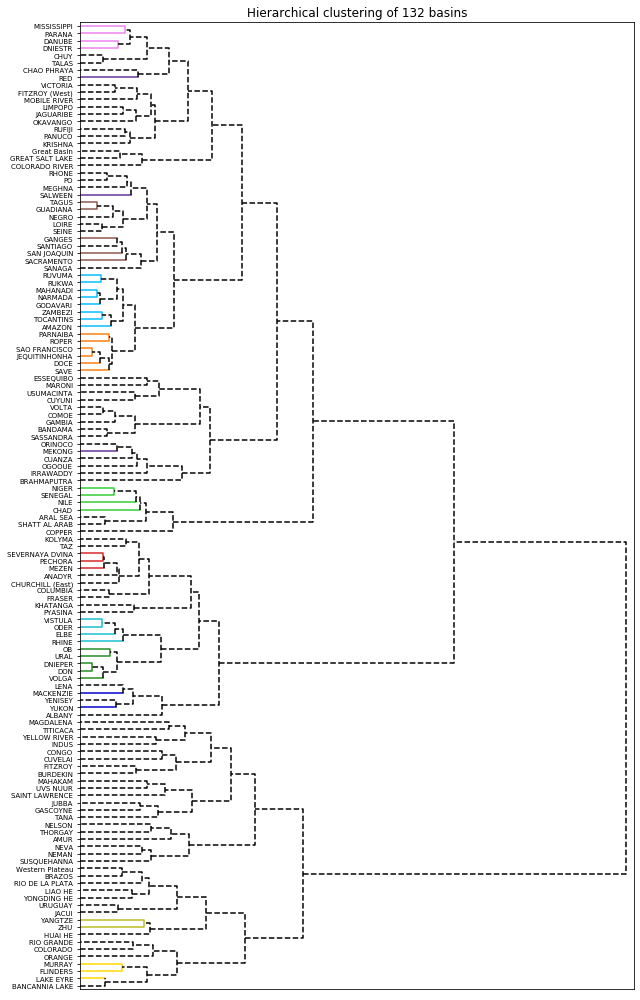

In [8]:
plt.figure(figsize=(9, 14))
plt.title('Hierarchical clustering of {} basins'.format(cost.shape[0]))
for lx,ly in zip(dend['icoord'],dend['dcoord']):
    if (lx[0]-5)%10==0 and ly[0]==0: # one part of the line is a leaf
        xcoord_basin1=int((lx[0]-5)//10)
        basin1=dend['ivl'][xcoord_basin1]
        cluster1=clusters.loc[basin1]
        
        if (lx[3]-5)%10==0 and ly[3]==0: # the other bound of the line is also a leaf
            xcoord_basin2=int((lx[3]-5)//10)
            basin2=dend['ivl'][xcoord_basin2]
            cluster2=clusters.loc[basin2]
            if cluster1!=0 and cluster1==cluster2: # if both basins belong to the same cluster
                plt.plot(ly,lx,color=dict_color_cluster[cluster1]) 
            elif cluster1!=0:
                plt.plot([ly[0],ly[1]],[lx[0],lx[1]],color=dict_color_cluster[cluster1])
                plt.plot([ly[1],ly[2],ly[3]],[lx[1],lx[2],lx[3]],'--',color='k')
            elif cluster2!=0:
                plt.plot([ly[2],ly[3]],[lx[2],lx[3]],color=dict_color_cluster[cluster2])
                plt.plot([ly[0],ly[1],ly[2]],[lx[0],lx[1],lx[2]],'--',color='k')
            else:
                plt.plot(ly,lx,'--',color='k')
        
        elif cluster1!=0:
            plt.plot([ly[0],ly[1]],[lx[0],lx[1]],color=dict_color_cluster[cluster1])
            plt.plot([ly[1],ly[2],ly[3]],[lx[1],lx[2],lx[3]],'--',color='k')                                              
        else:
            plt.plot(ly,lx,'--',color='k')
    else:
        plt.plot(ly,lx,'--',color='k')
plt.yticks(np.arange(5,10*cost.shape[0],10),
           dend['ivl'],
           fontsize=7)
plt.ylim([0,10*cost.shape[0]])
plt.xticks([],[])
plt.xlim([0,200])
plt.tight_layout()
plt.show()

Plot the new clusters

In [9]:
# world maps to serve as a background
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

# basins shapes
basins=geopandas.read_file('data/basins/basins.shp').set_index('name')

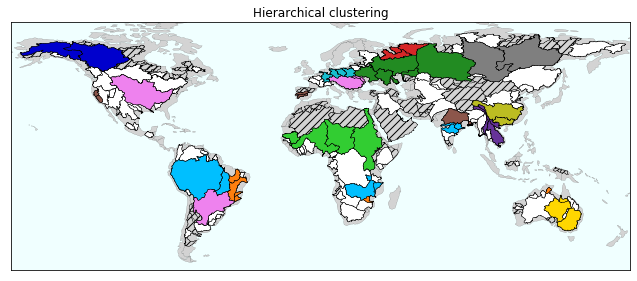

In [10]:
basins_plot=basins.copy()
basins_plot['cluster']=np.nan
basins_plot.loc[(clusters!=0).index,'cluster']=clusters.loc[clusters!=0]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,edgecolor='black',linewidth=0.4,facecolor='lightgrey',hatch='///')
basins.loc[good_basins].plot(ax=ax,edgecolor='black',linewidth=0.4,facecolor='white')

for cluster,color in zip(dict_color_cluster.keys(),dict_color_cluster.values()):
    basins_plot.loc[basins_plot['cluster']==cluster].plot(ax=ax,edgecolor='black',linewidth=0.4,
                 facecolor=color)

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,80])
ax.set_title('Hierarchical clustering')
plt.tight_layout()
plt.show()

# 2. Select combinations suitable in all basins of a cluster

Retrieve all datasets used to compute the NSE tables.

In [11]:
temp=np.array(list(map(decompose_combination,NSE_tab.columns)))
list_data_P=np.unique(temp[:,0])
list_data_ET=np.unique(temp[:,1])
list_data_R=np.unique(temp[:,2])

For each basin and each dataset, compute the annual mean of the timeseries to perform the normalization.

In [12]:
annual_P=pd.DataFrame(index=basins.index,columns=list_data_P)
for data in list_data_P:
    hydro_monthly=pd.read_csv('data/hydrology_timeseries/P_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_monthly.columns=hydro_monthly.columns.astype('datetime64[ns]')
    temp=hydro_monthly.T
    temp['year']=temp.index.year
    annual_values=temp.groupby('year').sum().T
    annual_P[data]=annual_values[np.arange(2003,2015)].mean(axis=1)

annual_ET=pd.DataFrame(index=basins.index,columns=list_data_ET)
for data in list_data_ET:
    hydro_monthly=pd.read_csv('data/hydrology_timeseries/ET_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_monthly.columns=hydro_monthly.columns.astype('datetime64[ns]')
    temp=hydro_monthly.T
    temp['year']=temp.index.year
    annual_values=temp.groupby('year').sum().T
    annual_ET[data]=annual_values[np.arange(2003,2015)].mean(axis=1)
    
annual_R=pd.DataFrame(index=basins.index,columns=list_data_R)
for data in list_data_R:
    hydro_monthly=pd.read_csv('data/hydrology_timeseries/R_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_monthly.columns=hydro_monthly.columns.astype('datetime64[ns]')
    temp=hydro_monthly.T
    temp['year']=temp.index.year
    annual_values=temp.groupby('year').sum().T
    annual_R[data]=annual_values[np.arange(2003,2015)].mean(axis=1)

Build dataframes to store the number of combinations in which each dataset appears

In [13]:
list_clusters=np.unique(clusters.loc[clusters!=0])
stats_P=pd.DataFrame(np.zeros((list_clusters.shape[0],len(list_data_P))),
                    index=list_clusters,
                    columns=list_data_P)
stats_ET=pd.DataFrame(np.zeros((list_clusters.shape[0],len(list_data_ET))),
                    index=list_clusters,
                    columns=list_data_ET)
stats_R=pd.DataFrame(np.zeros((list_clusters.shape[0],len(list_data_R))),
                    index=list_clusters,
                    columns=list_data_R)

In each cluster, select the combinations leading to a cost lower than the threshold in all basins of the cluster.

In [14]:
max_cost=0.1

cost_df=pd.DataFrame(cost,index=good_basins,columns=NSE_tab.columns)
for k in list_clusters:
    # name of all basins inside the cluster
    basins_in_cluster=clusters.loc[clusters==k].index

    # cost of all combinations inside the cluster
    cost_cluster=cost_df.loc[basins_in_cluster]

    # list of combinations where the cost is below the maximum for all basins
    suitable_combinations=cost_cluster.columns[np.sum(cost_cluster<=max_cost,axis=0)==basins_in_cluster.shape[0]]
    
    # extract the datasets in the combinations
    temp=np.array(list(map(decompose_combination,suitable_combinations)))

    # from the list of all precipitation datasets in the combinations (temp[:,0]), 
    # find the number of combinations where each dataset appears (counts_P)
    unique_P,counts_P=np.unique(temp[:,0],return_counts=True)
    stats_P.loc[k,unique_P]=counts_P/suitable_combinations.shape[0] # normalize to [0,1] by the number of combinations
    P_mean=annual_P.loc[basins_in_cluster,unique_P].sum(axis=0).mean() # sum over basins and mean across datasets

    unique_ET,counts_ET=np.unique(temp[:,1],return_counts=True)
    stats_ET.loc[k,unique_ET]=counts_ET/suitable_combinations.shape[0]
    ET_mean=annual_ET.loc[basins_in_cluster,unique_ET].sum(axis=0).mean() # sum over basins and mean across datasets
    stats_ET.loc[k,unique_ET]=stats_ET.loc[k,unique_ET]*ET_mean/P_mean

    unique_R,counts_R=np.unique(temp[:,2],return_counts=True)
    stats_R.loc[k,unique_R]=counts_R/suitable_combinations.shape[0]
    R_mean=annual_R.loc[basins_in_cluster,unique_R].sum(axis=0).mean() # sum over basins and mean across datasets
    stats_R.loc[k,unique_R]=stats_R.loc[k,unique_R]*R_mean/P_mean
    
    print('cluster ',k)
    #print(basins_in_cluster)
    print('{} suitable combinations'.format(suitable_combinations.shape[0]))
    print('\n')

cluster  Amazon
12 suitable combinations


cluster  Brazil
19 suitable combinations


cluster  Central Africa
32 suitable combinations


cluster  East Australia
10 suitable combinations


cluster  Elbe
9 suitable combinations


cluster  Ganges
8 suitable combinations


cluster  Lena
12 suitable combinations


cluster  Mackenzie
7 suitable combinations


cluster  Mekong
9 suitable combinations


cluster  Mississippi
7 suitable combinations


cluster  Volga
11 suitable combinations


cluster  West Russia
32 suitable combinations


cluster  Yangtze
8 suitable combinations




## Fig. 12: Map with bars for each dataset

Function to plot the color bars in each cluster

In [15]:
def plot_bars(x,y,cluster,ax,height=5,length_total=30):
    ''' (x,y) are the coordinates of the box
    cluster is the name of the current cluster being drawn
    ax is the current ax
    height is the height of the bar (in pixels)
    length_total is the total length of the precipitations bar
    '''
    # P
    left=x
    for data in list_data_P:
        length=length_total*stats_P.loc[cluster,data]
        ax.barh(y+2*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length
    
    # ET
    left=x
    for data in list_data_ET:
        length=length_total*stats_ET.loc[cluster,data]
        ax.barh(y+0.6*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length
    
    # R
    plt.plot([left,left],[y+0.1*height,y+1.1*height],'k',linewidth=2) # separating black line
    for data in list_data_R:
        length=length_total*stats_R.loc[cluster,data]
        ax.barh(y+0.6*height,length,left=left,
                 label=dict_dataset_name[data],color=colors_dataset[data],height=height)
        left+=length

Coordinates of the cluster box on the map

In [16]:
cluster_coord=pd.DataFrame(index=list_clusters,columns=['x','y'])
cluster_coord.loc['Amazon']=[-120,-15]
cluster_coord.loc['Brazil']=[-30,-25]
cluster_coord.loc['Central Africa']=[-50,5]
cluster_coord.loc['West Russia']=[5,64]
cluster_coord.loc['Mississippi']=[-70,25]
cluster_coord.loc['Ganges']=[65,-7]
cluster_coord.loc['East Australia']=[130,-55]
cluster_coord.loc['Lena']=[143,40]
cluster_coord.loc['Mekong']=[120,2]
cluster_coord.loc['Elbe']=[-35,45]
cluster_coord.loc['Volga']=[40,30]
cluster_coord.loc['Yangtze']=[128,22]
cluster_coord.loc['Mackenzie']=[-160,35]

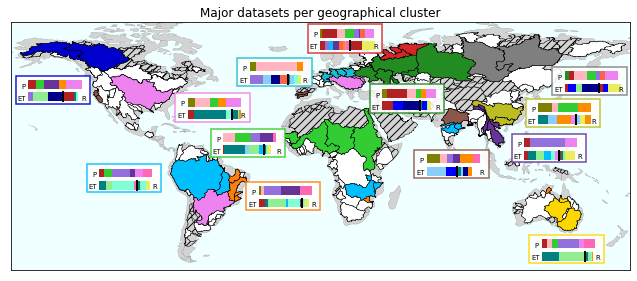

In [17]:
basins_plot=basins.copy()
basins_plot['cluster']=np.nan
basins_plot.loc[(clusters!=0).index,'cluster']=clusters.loc[clusters!=0]

fig, ax = plt.subplots(figsize=(9.7,4))
ax.set_aspect('equal')
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
basins.plot(ax=ax,edgecolor='black',linewidth=0.4,facecolor='lightgrey',hatch='///')
basins.loc[good_basins].plot(ax=ax,edgecolor='black',linewidth=0.4,facecolor='white')

for cluster,color in zip(dict_color_cluster.keys(),dict_color_cluster.values()):
    basins_plot.loc[basins_plot['cluster']==cluster].plot(ax=ax,edgecolor='black',linewidth=0.4,
                 facecolor=color)
    # draw the white box with colored edges
    ax.fill([cluster_coord.loc[cluster,'x']-7,cluster_coord.loc[cluster,'x']+35,cluster_coord.loc[cluster,'x']+35,cluster_coord.loc[cluster,'x']-7],
           [cluster_coord.loc[cluster,'y']-1,cluster_coord.loc[cluster,'y']-1,cluster_coord.loc[cluster,'y']+15,cluster_coord.loc[cluster,'y']+15],
           facecolor='white',alpha=0.9,
            edgecolor=dict_color_cluster[cluster],linewidth=1.5)
    
    # datasets bars
    plot_bars(cluster_coord.loc[cluster,'x'],cluster_coord.loc[cluster,'y'],cluster,ax)
    
    # letters
    plt.text(cluster_coord.loc[cluster,'x']-4,cluster_coord.loc[cluster,'y']+8,'P',fontsize='x-small')
    plt.text(cluster_coord.loc[cluster,'x']-6,cluster_coord.loc[cluster,'y']+1.2,'ET',fontsize='x-small')
    plt.text(cluster_coord.loc[cluster,'x']+30,cluster_coord.loc[cluster,'y']+1.2,'R',fontsize='x-small')

ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,80])
ax.set_title('Major datasets per geographical cluster')
plt.tight_layout()
plt.show()

# 3. Suitable combinations in individual basins

For each basin, plot the number of combinations with a cost lower than the threshold.

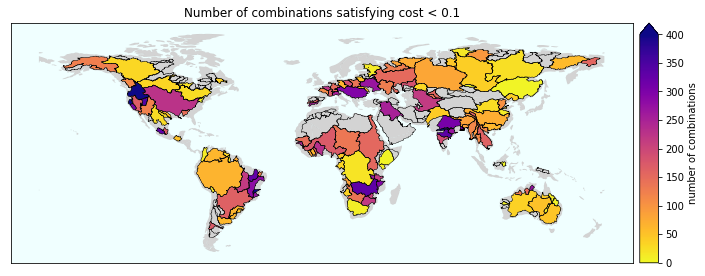

In [18]:
basins_plot=basins.loc[good_basins].copy()
basins_plot['nb comb ok']=np.sum(cost_df<max_cost,axis=1)

fig, ax = plt.subplots(figsize=(9.9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.01)
basins.boundary.plot(ax=ax,color='black',linewidth=0.4)
#basins.plot(ax=ax,color='grey',edgecolor='black',linewidth=0.5)
basins_plot.plot(ax=ax,column='nb comb ok',edgecolor='grey',linewidth=0.1,
                 cmap=plt.cm.get_cmap('plasma_r'),
                 vmin=0,
                 vmax=400,
                 legend=True,cax=cax,
                legend_kwds={'label': "number of combinations",
                             'extend':'max'
                          },)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('azure')
ax.set_title('Number of combinations satisfying cost < {}'.format(max_cost))
plt.tight_layout()
plt.show()

In [19]:
print('{} combinations are suitable in 50% of the basins'.format(np.percentile(basins_plot['nb comb ok'],50)))
print('{} combinations are suitable in 25% of the basins'.format(np.percentile(basins_plot['nb comb ok'],75)))

112.0 combinations are suitable in 50% of the basins
185.25 combinations are suitable in 25% of the basins


Store all timeseries, this will be used after to compute the discrepancy.

In [20]:
time_idx=pd.date_range('2003-02-01','2014-12-01',freq='MS')
multi_index_P=pd.MultiIndex.from_product([list_data_P,list(good_basins)], names=["dataset", "basin"])
# each row of temp is a timeseries for a basin and a dataset
df_all_data_P=pd.DataFrame(index=multi_index_P,columns=time_idx[1:-1])
for data in list_data_P:
    hydro_month=pd.read_csv('data/hydrology_timeseries/P_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    df_all_data_P.loc[data]=hydro_month.loc[good_basins,time_idx[1:-1]].values
# invert indices
df_all_data_P=df_all_data_P.reset_index().set_index(['basin','dataset'])
    
# same for ET
multi_index_ET=pd.MultiIndex.from_product([list_data_ET,list(good_basins)], names=["dataset", "basin"])
df_all_data_ET=pd.DataFrame(index=multi_index_ET,columns=time_idx[1:-1])
for data in list_data_ET:
    hydro_month=pd.read_csv('data/hydrology_timeseries/ET_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    df_all_data_ET.loc[data]=hydro_month.loc[good_basins,time_idx[1:-1]].values
df_all_data_ET=df_all_data_ET.reset_index().set_index(['basin','dataset'])

# same for R
multi_index_R=pd.MultiIndex.from_product([list_data_R,list(good_basins)], names=["dataset", "basin"])
df_all_data_R=pd.DataFrame(index=multi_index_R,columns=time_idx[1:-1])
for data in list_data_R:
    hydro_month=pd.read_csv('data/hydrology_timeseries/R_{}_monthly_filtered.csv'.format(data),index_col=[0])
    hydro_month.columns=hydro_month.columns.astype('datetime64[ns]')
    df_all_data_R.loc[data]=hydro_month.loc[good_basins,time_idx[1:-1]].values
df_all_data_R=df_all_data_R.reset_index().set_index(['basin','dataset'])

For each basin, select the suitable combinations and extract the underlying datasets.

In [21]:
index_basins=dend['ivl'][105:] #[61:105] #[30:61] #[:30]
min_percentage=0.05 # keep only datasets appearing in at least 10% of the combinations to avoid false positives
stats_P=pd.DataFrame(0,index=index_basins,columns=list_data_P)
stats_ET=pd.DataFrame(0,index=index_basins,columns=list_data_ET)
stats_R=pd.DataFrame(0,index=index_basins,columns=list_data_R)

discrepancy=pd.DataFrame(index=index_basins,columns=['P','ET','R'])

cost_df=pd.DataFrame(cost,index=good_basins,columns=NSE_tab.columns)
for basin_name in stats_P.index:
    # list of combinations where the cost is below the maximum
    suitable_combinations=cost_df.loc[basin_name,cost_df.loc[basin_name]<=max_cost].index
    
    # extract the datasets in the combinations
    temp=np.array(list(map(decompose_combination,suitable_combinations)))
    
    # from the list of all precipitation datasets in the combinations (temp[:,0]), 
    # find the number of combinations where each dataset appears (counts_P)
    unique_P,counts_P=np.unique(temp[:,0],return_counts=True)
    stats_P.loc[basin_name,unique_P]=counts_P/suitable_combinations.shape[0] # normalize to [0,1] by the number of combinations
    # remove datasets appearing in less than min_percentage of the combinations
    stats_P.loc[basin_name,unique_P]=np.where(stats_P.loc[basin_name,unique_P]<=min_percentage,0,
                                              stats_P.loc[basin_name,unique_P])
    P_mean=annual_P.loc[basin_name,unique_P].mean() # mean across datasets
    
    # ET
    unique_ET,counts_ET=np.unique(temp[:,1],return_counts=True)
    stats_ET.loc[basin_name,unique_ET]=counts_ET/suitable_combinations.shape[0]
    stats_ET.loc[basin_name,unique_ET]=np.where(stats_ET.loc[basin_name,unique_ET]<=min_percentage,0,
                                              stats_ET.loc[basin_name,unique_ET])
    ET_mean=annual_ET.loc[basin_name,unique_ET].mean() # mean across datasets
    stats_ET.loc[basin_name,unique_ET]=stats_ET.loc[basin_name,unique_ET]*ET_mean/P_mean
    
    # R
    unique_R,counts_R=np.unique(temp[:,2],return_counts=True)
    stats_R.loc[basin_name,unique_R]=counts_R/suitable_combinations.shape[0]
    stats_R.loc[basin_name,unique_R]=np.where(stats_R.loc[basin_name,unique_R]<=min_percentage,0,
                                              stats_R.loc[basin_name,unique_R])
    R_mean=annual_R.loc[basin_name,unique_R].mean() # mean across datasets
    stats_R.loc[basin_name,unique_R]=stats_R.loc[basin_name,unique_R]*R_mean/P_mean
    
    # discrepancy
    temp=df_all_data_P.loc[basin_name].loc[unique_P]
    discr_ts=(np.nanmax(temp,axis=0)-np.nanmin(temp,axis=0))/temp.mean(axis=0)
    discrepancy.loc[basin_name,'P']=discr_ts.mean()
    
    temp=df_all_data_ET.loc[basin_name].loc[unique_ET]
    discr_ts=(np.nanmax(temp,axis=0)-np.nanmin(temp,axis=0))/temp.mean(axis=0)
    discrepancy.loc[basin_name,'ET']=discr_ts.mean()
    
    temp=df_all_data_R.loc[basin_name].loc[unique_R]
    discr_ts=(np.nanmax(temp,axis=0)-np.nanmin(temp,axis=0))/temp.mean(axis=0)
    discrepancy.loc[basin_name,'R']=discr_ts.mean()

For each basin, plot the suitable datasets

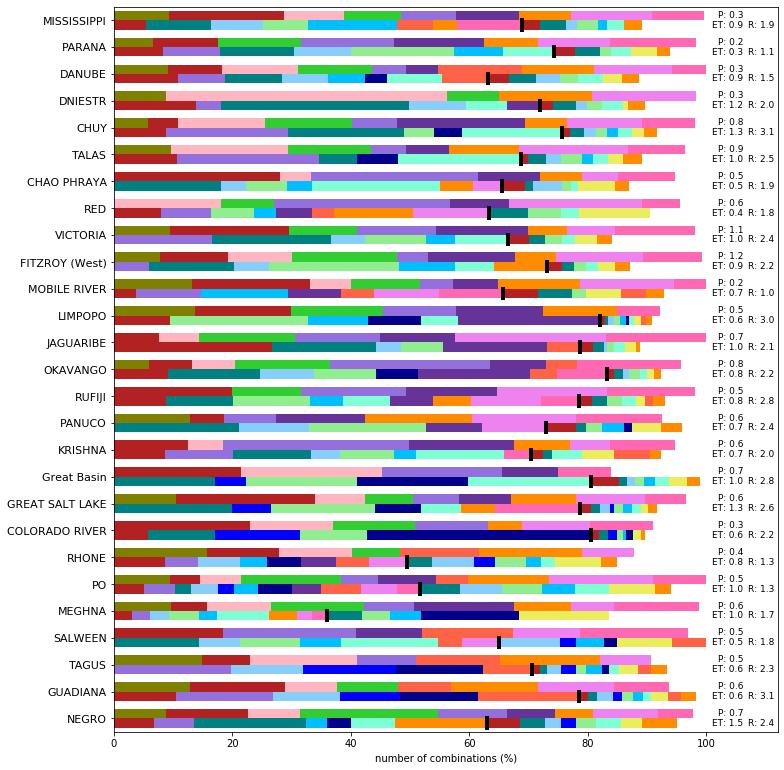

In [22]:
height=0.35

plt.figure(figsize=(11,0.4*stats_P.shape[0]))
# P
left=pd.Series(np.zeros(stats_P.shape[0]),index=stats_P.index)
for data in list_data_P:
    plt.barh(np.arange(stats_P.shape[0])+height/2,stats_P[data],left=left,
             label=dict_dataset_name[data],color=colors_dataset[data],height=height)
    left+=stats_P[data]

# ET
left=pd.Series(np.zeros(stats_ET.shape[0]),index=stats_ET.index)
for data in list_data_ET:
    plt.barh(np.arange(stats_P.shape[0])-height/2,stats_ET[data],left=left,
             label=dict_dataset_name[data],color=colors_dataset[data],height=height)
    left+=stats_ET[data]

# R
plt.plot([left,left],[np.arange(stats_P.shape[0])-height,np.arange(stats_P.shape[0])],'k',linewidth=4)
for data in list_data_R:
    plt.barh(np.arange(stats_P.shape[0])-height/2,stats_R[data],left=left,
             label=dict_dataset_name[data],color=colors_dataset[data],height=height)
    left+=stats_R[data]

for y,basin_name in enumerate(discrepancy.index):
    text='P: {}'.format(np.round(discrepancy.loc[basin_name,'P'],1))
    plt.text(1.02,y+0.6*height/2,text,fontsize=9)
    text='ET: {}'.format(np.round(discrepancy.loc[basin_name,'ET'],1))
    plt.text(1.01,y-1.5*height/2,text,fontsize=9)
    text='R: {}'.format(np.round(discrepancy.loc[basin_name,'R'],1))
    plt.text(1.07,y-1.5*height/2,text,fontsize=9)
    
plt.xticks(np.arange(0,1.1,0.2),(100*np.arange(0,1.1,0.2)).astype(int))
plt.yticks(np.arange(stats_P.shape[0]),
           stats_P.index,
          fontsize=11)
plt.xlabel('number of combinations (%)')
plt.xlim([0,1.12])
plt.ylim([-0.5,stats_P.shape[0]-0.5])
plt.title('')

plt.tight_layout()
plt.show()

## Details in a basin

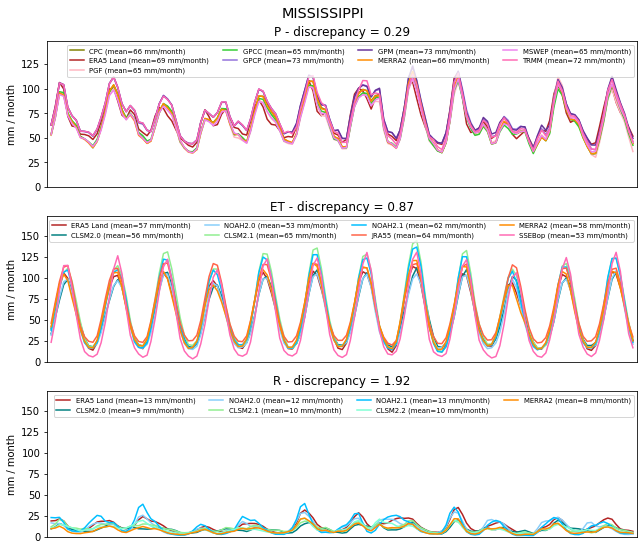

In [23]:
basin_name='MISSISSIPPI'
unique_P=stats_P.loc[basin_name,stats_P.loc[basin_name]>0].index
unique_ET=stats_ET.loc[basin_name,stats_ET.loc[basin_name]>0].index
unique_R=stats_R.loc[basin_name,stats_R.loc[basin_name]>0].index

vmax=0
plt.figure(figsize=(9.1,8))
plt.subplot(3,1,1)
for data in unique_P:
    plt.plot(df_all_data_P.loc[basin_name,data], 
             color=colors_dataset[data],
             label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
                df_all_data_P.loc[basin_name,data].mean()))
    vmax=max(vmax,df_all_data_P.loc[basin_name,data].max())
plt.legend(ncol=4,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.2*vmax])
plt.title('P - discrepancy = {:.2f}'.format(discrepancy.loc[basin_name,'P']))
plt.xticks([2008],[''])
plt.ylabel("mm / month")

# ET
plt.subplot(3,1,2)
for data in unique_ET:
    plt.plot(df_all_data_ET.loc[basin_name,data], 
             color=colors_dataset[data],
             label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
                df_all_data_ET.loc[basin_name,data].mean()))
    vmax=max(vmax,df_all_data_ET.loc[basin_name,data].max())
plt.legend(ncol=4,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.2*vmax])
plt.title('ET - discrepancy = {:.2f}'.format(discrepancy.loc[basin_name,'ET']))
plt.xticks([2008],[''])
plt.ylabel("mm / month")

# R
plt.subplot(3,1,3)
for data in unique_R:
    plt.plot(df_all_data_R.loc[basin_name,data], 
             color=colors_dataset[data],
             label='{} (mean={:.0f} mm/month)'.format(dict_dataset_name[data],
                df_all_data_R.loc[basin_name,data].mean()))
    vmax=max(vmax,df_all_data_R.loc[basin_name,data].max())
plt.legend(ncol=4,fontsize='x-small')
plt.xlim([time_idx[0],time_idx[-1]])
plt.ylim([0,1.2*vmax])
plt.title('R - discrepancy = {:.2f}'.format(discrepancy.loc[basin_name,'R']))
plt.xticks([2008],[''])
plt.ylabel("mm / month")

plt.suptitle("{}".format(basin_name),fontsize='x-large')
plt.subplots_adjust(left=0.08,right=0.98,bottom=0.06,top=0.92)
plt.show()

In [24]:
combinations_basin=[]
for data_P in unique_P:
    for data_ET in unique_ET:
        for data_R in unique_R:
            combinations_basin.append('P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS))
print('Combining any of the highlighted datasets leads to the following NSE values:')
NSEc_tab.loc[basin_name,combinations_basin].sort_values(ascending=False)

Combining any of the highlighted datasets leads to the following NSE values:


P_ERA5_Land_ET_GLDAS20_CLSM25_R_ERA5_Land_TWS_GRACE_JPL_mascons    0.469833
P_ERA5_Land_ET_GLDAS20_NOAH36_R_ERA5_Land_TWS_GRACE_JPL_mascons    0.424991
P_ERA5_Land_ET_MERRA2_R_GLDAS22_CLSM25_TWS_GRACE_JPL_mascons       0.348918
P_ERA5_Land_ET_MERRA2_R_GLDAS21_CLSM25_TWS_GRACE_JPL_mascons       0.342684
P_ERA5_Land_ET_MERRA2_R_GLDAS20_CLSM25_TWS_GRACE_JPL_mascons       0.341993
                                                                     ...   
P_MERRA2_ET_JRA55_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons          -2.422278
P_CPC_ET_JRA55_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons             -2.509759
P_GPCC_ET_JRA55_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons            -2.593479
P_MSWEP_ET_JRA55_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons           -2.620569
P_GLDAS20_ET_JRA55_R_GLDAS21_NOAH36_TWS_GRACE_JPL_mascons         -2.773539
Name: MISSISSIPPI, Length: 504, dtype: float64